In [109]:
import os
import pandas as pd
import numpy as np

import processing as proc
import processing_new as newproc

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters
import matplotlib.pyplot as plt

In [48]:
!ls saved_models
models = os.popen("ls saved_models").read().split('\n')[:-1]
tf_model = keras.models.load_model('saved_models/'+models[-1])

mnist_5epochs_20191028.h5  mnist_hasyv2_20epochs_201910291572394063.h5


In [237]:
imgs = os.popen("ls testmarker").read().split('\n')[:-1]
for i,img in enumerate(imgs):
    imgs[i]='testmarker/'+img
imgs
# imgs = os.popen("ls generated_imageset").read().split('\n')[:-1]
# for i,img in enumerate(imgs):
#     imgs[i]='generated_imageset/'+img
# imgs

['testmarker/2185.jpg', 'testmarker/7493.jpg']

In [238]:
labels = []
for filename in imgs:
    label = []
    for digit in filename[-8:-4]:
        label.append(int(digit))
    labels.append(label)
labels

[[2, 1, 8, 5], [7, 4, 9, 3]]

In [239]:
df = pd.DataFrame(imgs)
df.columns = ['filename']
df['label'] = labels
# df.to_csv('prepared_labels.csv',index=False)

In [240]:
# prepared = df.as_matrix()
df_subset = df.copy()     #.iloc[:1000]
df_subset

,filename,label
0,testmarker/2185.jpg,"[2, 1, 8, 5]"
1,testmarker/7493.jpg,"[7, 4, 9, 3]"


In [10]:
# proc.main(prepared[:5],tf=True,fitted_clf=tf_model)

In [7]:
# predictions = []
# with open('test_new_model__subset.txt','w') as writeFile:
#     for index,image in enumerate(df_subset['filename'].iloc[1:]):
#         matname = 'tf22/HANDWRITING__'+image[-8:-4]
#         print(index+1,'of',len(df_subset))
# #         print('processing ',image)
#         pred = proc.process_image(image,matname,tf_model,plot=False,tf=True,photo=True)
#         predictions.append(pred)
#         row = str(df_subset.iloc[index]['label'])+'; '+str(list(pred))+'\n'
# #         print(row)
#         writeFile.write(row)
# writeFile.close()


1 of 2
processing  testmarker/7493.jpg


TypeError: 'NoneType' object is not iterable

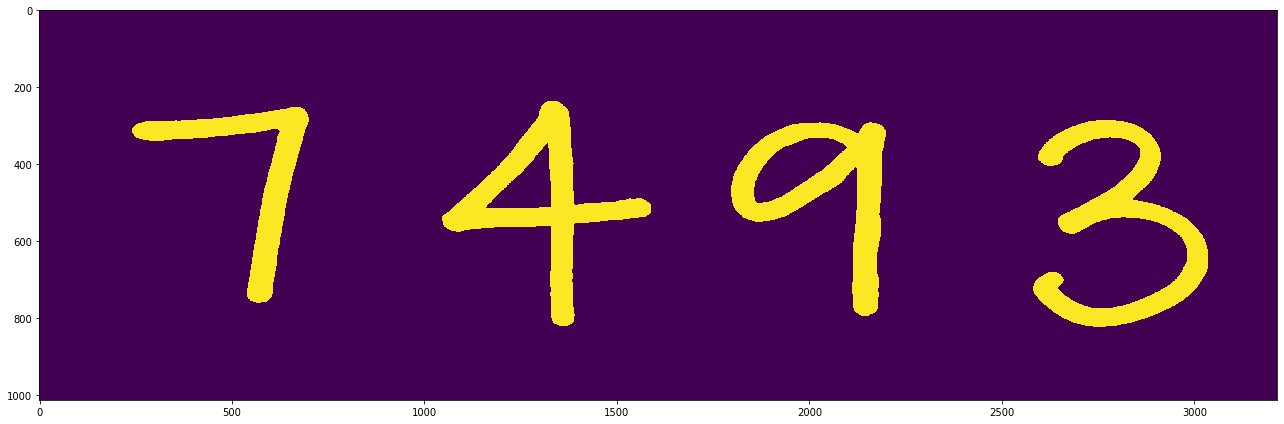

In [242]:
predictions = []
with open('test_new_model__subset.txt','w') as writeFile:
    for index,image in enumerate(df_subset['filename'].iloc[1:]):
        matname = 'tf22/HANDWRITING__'+image[-8:-4]
        print(index+1,'of',len(df_subset))
        print('processing ',image)
        binary_arr,label_arr, segments,orig = proc.label_segments(image,matname,photo=True)
        predicted = []
        for seg in segments:
            try:
                pred = proc.crop_image(seg,label_arr,orig,model=tf_model,direc=matname,svc=False,tf=True)[1]
            except:
                pred = None
            if pred!= None: predicted.append(pred)
        predictions.append(predicted)
        row = str(df_subset.iloc[index]['label'])+'; '+str(list(pred))+'\n'
        print(row)
        writeFile.write(row)
writeFile.close()


1 of 2
processing  testmarker/2185.jpg
[2, 1, 8, 5]; [2, 1, 8, 5]

2 of 2
processing  testmarker/7493.jpg
[7, 4, 9, 3]; [9, 4, 9, 3]



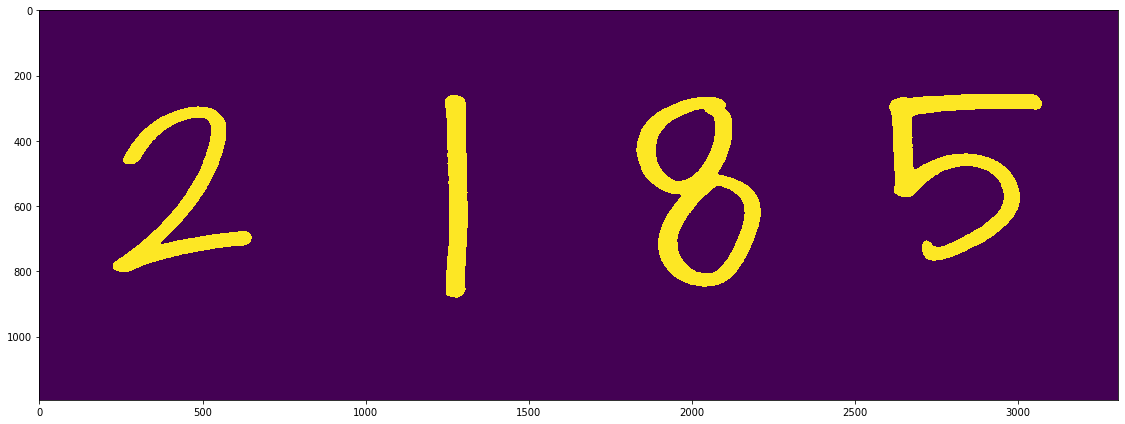

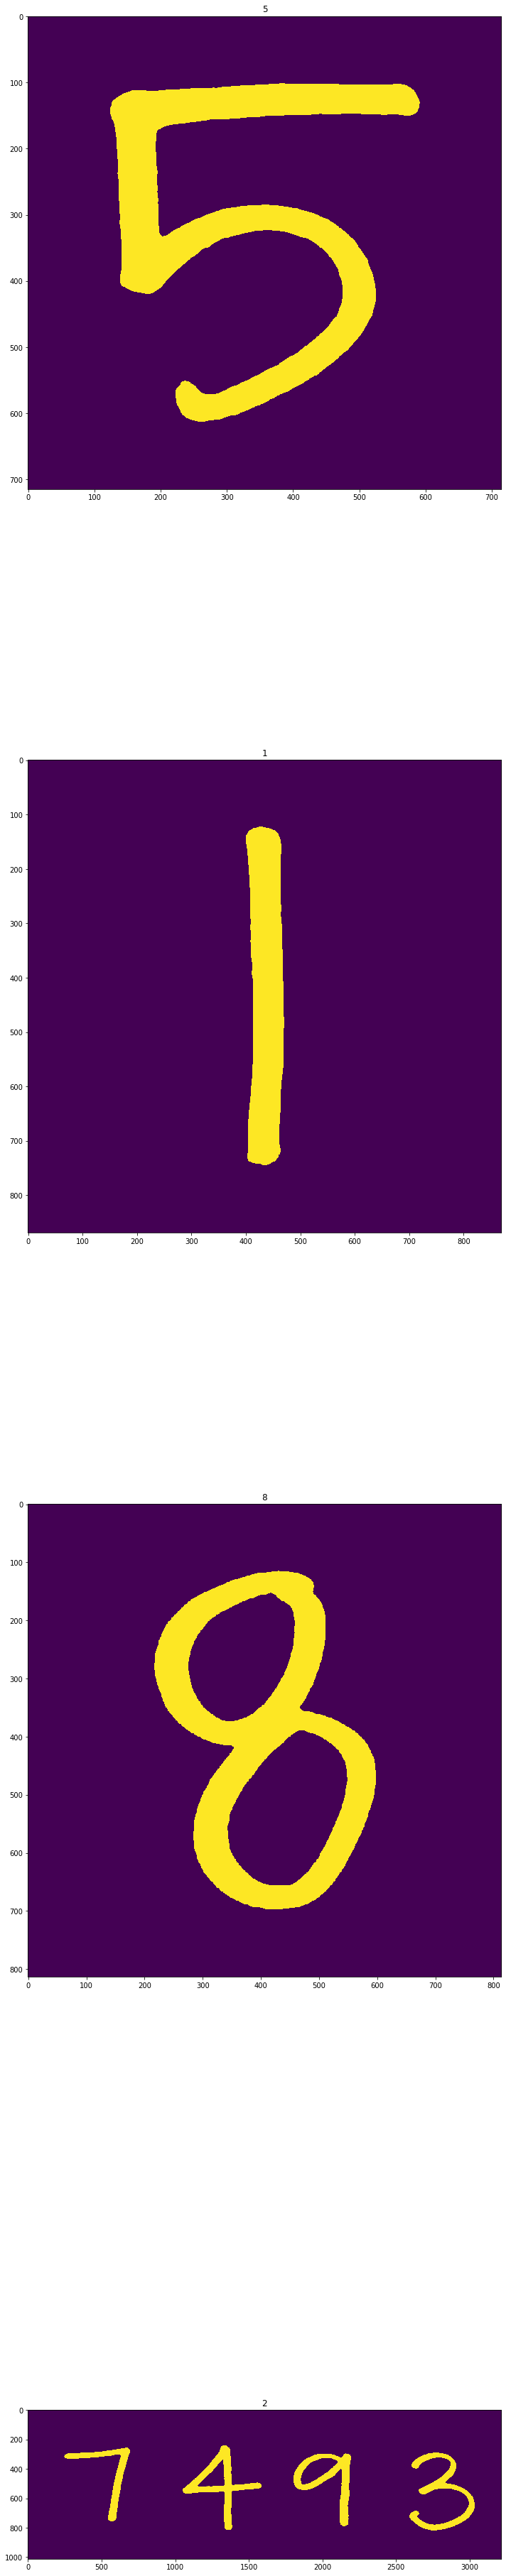

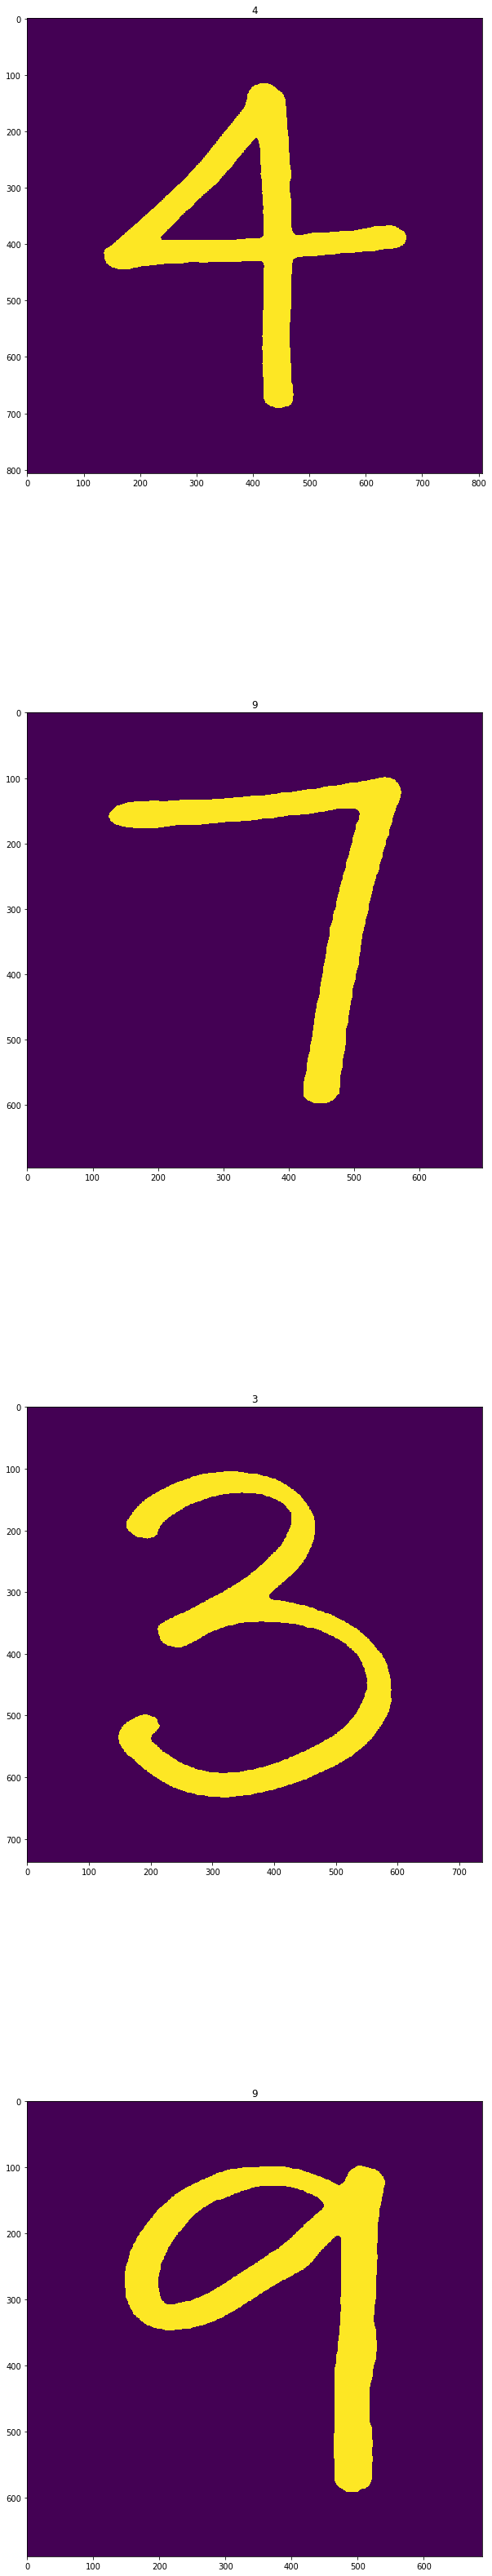

In [259]:
predictions = []
with open('test_new_model__subset.txt','w') as writeFile:
    for index,image in enumerate(df_subset['filename']):
        matname = 'tf22/HANDWRITING__'+image[-8:-4]
        print(index+1,'of',len(df_subset))
        print('processing ',image)
        binary_arr,label_arr, segments,orig = proc.label_segments(image,matname,photo=True,marker=True)
        
        predicted = []
        fig,axes = plt.subplots(len(segments),figsize=(10,60))
        for seg,ax in list(zip(segments,axes.flatten())):
            found = label_arr==seg
            x,y = np.where(found)
            xmin,xmax,ymin,ymax = np.min(x),np.max(x),np.min(y),np.max(y)
            xlen,ylen = found[xmin:xmax,ymin:ymax].shape
            diff = np.abs(ylen-xlen)
            change = ceil(diff/2)
            if diff!=0:
                if ylen>xlen:
                    xmin-=change
                    xmax+=change

                else:
                    ymin-=change
                    ymax+=change

                xlen,ylen = xmax-xmin,ymax-ymin
                diff=np.abs(ylen-xlen)
                if xlen>ylen: ymax+=diff
                elif ylen>xlen: xmax+=diff
            digit = binary_arr[xmin:xmax,ymin:ymax]
            digit = np.pad(digit,int(len(digit)*.2),mode= 'constant', constant_values=(0,0))        
            if digit.shape[0]<10:
                ax.set_visible(False)       
                pass
            else:
                ax.imshow(digit)
                im = Image.fromarray(np.array(digit)*255.0).convert("RGB")
                im.save('000.png')
                img = cv2.resize(cv2.imread('000.png',cv2.IMREAD_GRAYSCALE),(28,28),interpolation=cv2.INTER_CUBIC)
                p = np.argmax(tf_model.predict(img.astype(float).flatten().reshape((1, 28, 28, 1))))
                ax.set_title(p)
                predicted.append([ymin,p])

        predicted.sort()    
        predicted = [pr[1] for pr in predicted]

        row = str(df_subset.iloc[index]['label'])+'; '+str(list(predicted))+'\n'
        print(row)
        writeFile.write(row)
        predictions.append(predicted)
writeFile.close()


In [305]:
# df_subset.to_csv('test_pred_tf3.csv',index=False)
predictions

[[], [], [], [], [], [], [], []]

In [393]:
imgs[0]

'testmarker/2185.jpg'

In [ ]:
label_arr

In [208]:
def plot_numbered_image(label_arr,savename='',no_rotate=False):
    IMAGE = savename+'_segmented.jpg'
    pixarray=np.rot90(label_arr,3)
    imax,jmax = pixarray.shape
    fig,ax=plt.subplots(ncols=1, nrows=1, figsize=(20,int(20*jmax/imax)))
    plt.xticks(np.arange(0,imax))
    plt.yticks(np.arange(0,jmax))
    for i in range(0,imax,2):
        for j in range(0,jmax,2):
            val = pixarray[i][j]
            if val != 0:
                ax.scatter(i,j,s=300,color='k')
#                 ax.text(i,j,8,fontsize=20)
#     ax.patch.set_facecolor('black')
    ax.set_axis_off()
    plt.xticks([])
    plt.yticks([])            
    plt.show()
    fig.savefig(IMAGE)
    
#     ORIG = cv2.imread(IMAGE)    
#     kernel = np.ones((10,10),np.float32)/25
#     GAUSS = cv2.blur(ORIG, (25, 25))    
# #     GAUSS = cv2.filter2D(ORIG,-1,kernel)
# #     GAUSS=cv2.medianblur(IMAGE,(5,5))
#     io.imsave(IMAGE,GAUSS)    
    
#     BLACK = plt.imread(IMAGE)
#     INVERT = cv2.bitwise_not(BLACK)
#     io.imsave(savename+'_segmented.jpg',INVERT)
#     return INVERT

testset/1093.jpg
[1, 0, 9, 3]


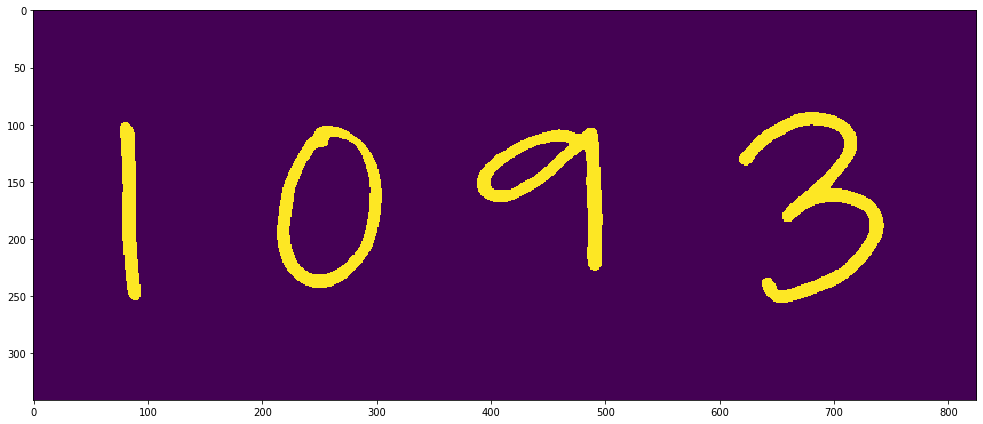

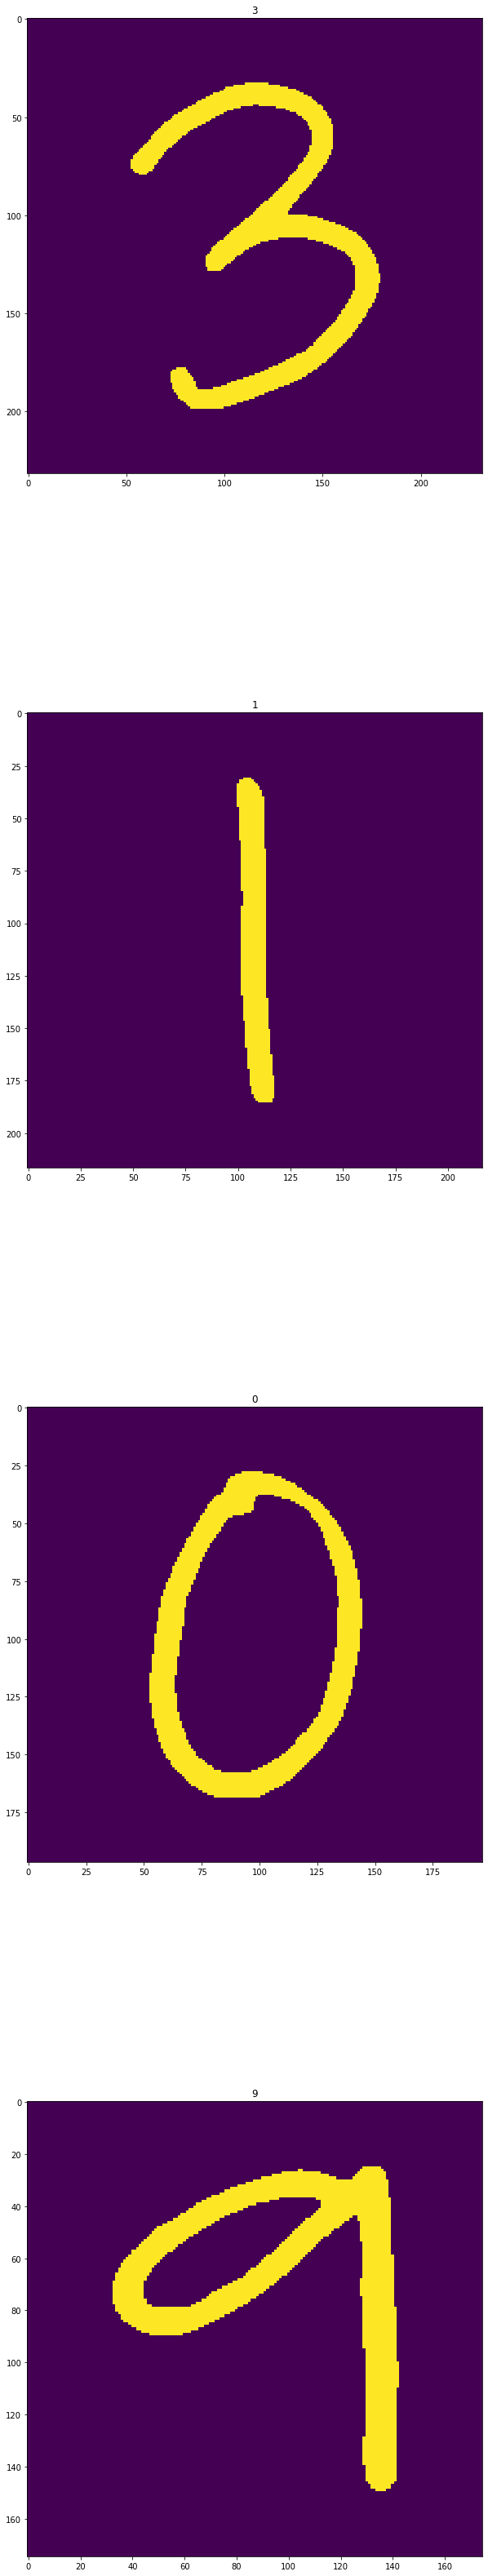

In [236]:
from math import ceil 
import cv2
from PIL import Image
IMAGE = "testset/1093.jpg"            ###imgs[0]
plt.imshow(io.imread(IMAGE))
binary_arr,label_arr, segments,orig = proc.label_segments(IMAGE,'',photo=True)
plt.imshow(np.array(binary_arr, dtype = np.uint8 ))

predictions = []
fig,axes = plt.subplots(len(segments),figsize=(10,60))
for seg,ax in list(zip(segments,axes.flatten())):
    found = label_arr==seg
    x,y = np.where(found)
    xmin,xmax,ymin,ymax = np.min(x),np.max(x),np.min(y),np.max(y)
    xlen,ylen = found[xmin:xmax,ymin:ymax].shape
    diff = np.abs(ylen-xlen)
    change = ceil(diff/2)
    if diff!=0:
        if ylen>xlen:
            xmin-=change
            xmax+=change

        else:
            ymin-=change
            ymax+=change

        xlen,ylen = xmax-xmin,ymax-ymin
        diff=np.abs(ylen-xlen)
        if xlen>ylen: ymax+=diff
        elif ylen>xlen: xmax+=diff
    digit = binary_arr[xmin:xmax,ymin:ymax]
    digit = np.pad(digit,int(len(digit)*.2),mode= 'constant', constant_values=(0,0))        
    

    if digit.shape[0]<10:
        ax.set_visible(False)       
        pass
    else:
        ax.imshow(digit)
        im = Image.fromarray(np.array(digit)*255.0).convert("RGB")
        im.save('000.png')
        img = cv2.resize(cv2.imread('000.png',cv2.IMREAD_GRAYSCALE),(28,28),interpolation=cv2.INTER_CUBIC)
        p = np.argmax(tf_model.predict(img.astype(float).flatten().reshape((1, 28, 28, 1))))
        ax.set_title(p)
        predictions.append([ymin,p])

predictions.sort()    
predictions = [pr[1] for pr in predictions]
print(IMAGE)
print(predictions)

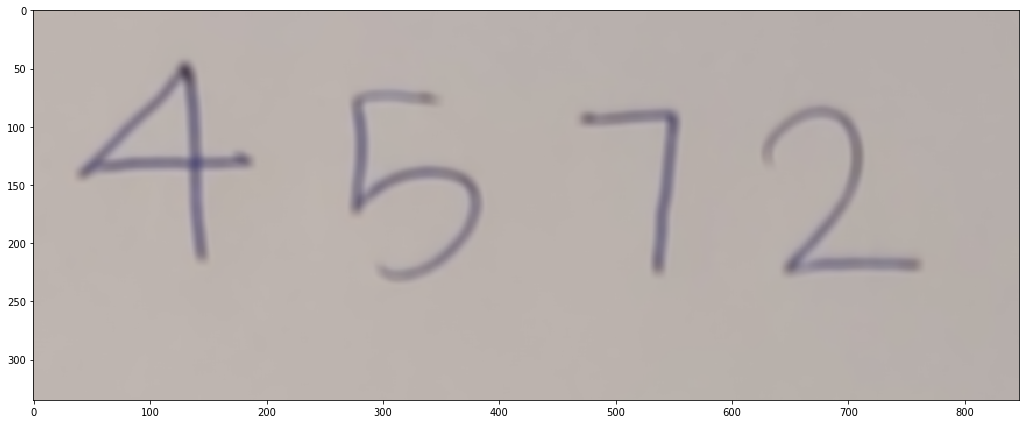

In [214]:
ORIG = io.imread(IMAGE)
GAUSS = cv2.blur(ORIG, (10, 10)) 
io.imshow(GAUSS)

In [98]:
results

array([1, 1, 1, 1], dtype=object)

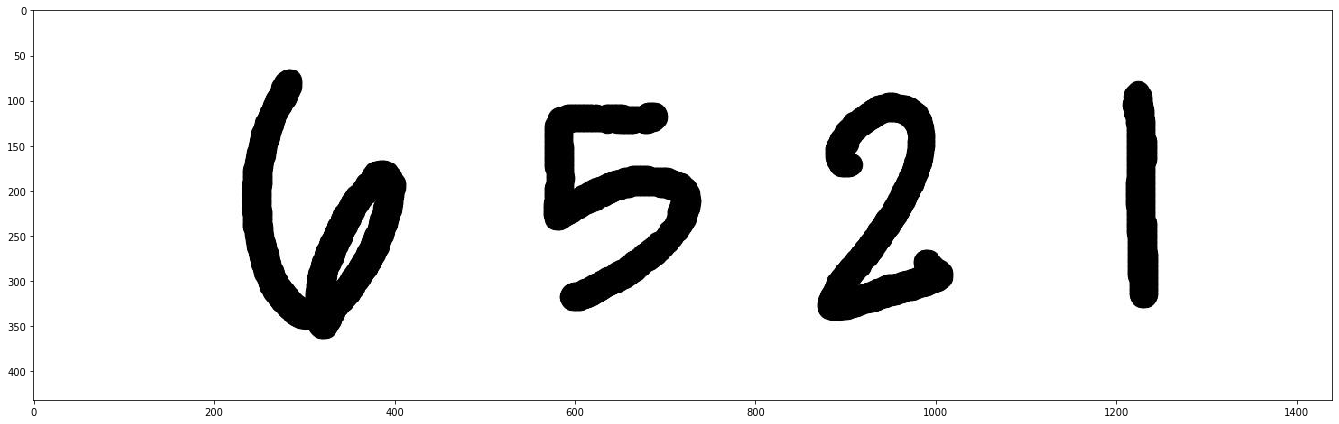

In [135]:
from skimage import io, filters, color
import cv2
BLACK = io.imread('_segmented.jpg')
INVERT = cv2.bitwise_not(BLACK)
io.imshow(INVERT)

In [ ]:
# plt.imshow(imgs[0])
print(imgs[0])
predictions

In [ ]:
df_subset['predict'] = predictions
df_subset

In [22]:
actual2 = []
predict2 = []

for i in range(len(df_subset)):
    actual2.append(np.array(df_subset)[i][1])
    predict2.append(list(df_subset.iloc[i]['predict'])    )


In [ ]:
proc.label_segments()

In [23]:
results = []
for i in range(len(df_subset)):
    results.append((np.array(actual2)[i]==np.array(predict2)[i])*1)
np.sum(np.sum(results))/(len(df_subset)*4)

/home/nina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0.86125

In [24]:
count_correct = []
for arr in results:
    count_correct.append(np.sum(arr))


In [25]:
all_correct = count_correct.count(4)
correct_3 = count_correct.count(3)
correct_2 = count_correct.count(2)
correct_1 = count_correct.count(1)
none_correct = count_correct.count(0)

In [26]:
print(all_correct,correct_3,correct_2,correct_1,none_correct)

583 312 82 13 10


In [27]:
print(all_correct,correct_3,correct_2,correct_1,none_correct)

583 312 82 13 10


In [31]:
N=len(results)/100

In [32]:
print(all_correct/N,correct_3/N,correct_2/N,correct_1/N,none_correct/N)

58.3 31.2 8.2 1.3 1.0


In [8]:
issues = [2,
 4,
 5,
 7,
 9,
 11,
 12,
 15,
 19,
 27,
 28,
 30,
 34,
 35,
 36,
 37,
 40,
 41,
 42,
 43,
 46,
 47,
 48,
 52,
 54,
 56,
 59,
 60,
 61,
 63,
 65,
 68,
 72,
 73,
 74,
 75,
 80,
 81,
 82,
 85,
 87,
 89,
 91,
 92,
 93,
 94,
 96,
 97,
 102,
 103,
 106,
 107,
 108,
 109,
 113,
 114,
 118,
 121,
 122,
 124,
 125,
 128,
 129,
 130,
 133,
 139,
 145,
 147,
 148,
 152,
 156,
 157,
 160,
 161,
 163,
 165,
 169,
 172,
 176,
 178,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 192,
 193,
 196,
 199,
 200,
 201,
 208,
 211,
 215,
 216,
 217,
 218,
 219,
 225,
 227,
 228,
 233,
 234,
 235,
 236,
 238,
 239,
 241,
 247,
 249,
 250,
 251,
 252,
 259,
 261,
 262,
 264,
 265,
 266,
 267,
 276,
 280,
 282,
 283,
 286,
 287,
 288,
 290,
 291,
 292,
 295,
 297,
 298,
 300,
 302,
 303,
 305,
 306,
 309,
 315,
 316,
 319,
 321,
 323,
 328,
 331,
 333,
 335,
 337,
 339,
 340,
 341,
 342,
 343,
 352,
 354,
 355,
 360,
 365,
 366,
 368,
 369,
 375,
 380,
 383,
 384,
 386,
 387,
 390,
 392,
 395,
 397,
 400,
 413,
 414,
 417,
 421,
 423,
 424,
 426,
 430,
 434,
 435,
 438,
 439,
 440,
 441,
 444,
 445,
 446,
 447,
 448,
 452,
 453,
 454,
 455,
 459,
 461,
 463,
 466,
 470,
 474,
 477,
 481,
 483,
 486,
 488,
 491,
 493,
 496,
 497,
 498,
 499,
 501,
 505,
 506,
 507,
 508,
 511,
 514,
 516,
 517,
 519,
 521,
 522,
 524,
 530,
 533,
 536,
 540,
 541,
 544,
 545,
 551,
 555,
 559,
 560,
 561,
 562,
 563,
 565,
 566,
 568,
 571,
 573,
 574,
 577,
 579,
 580,
 581,
 584,
 585,
 588,
 594,
 595,
 598,
 599,
 601,
 602,
 603,
 612,
 614,
 615,
 617,
 618,
 620,
 622,
 626,
 632,
 633,
 641,
 643,
 644,
 647,
 648,
 649,
 652,
 653,
 655,
 657,
 658,
 659,
 660,
 661,
 663,
 668,
 671,
 672,
 680,
 685,
 686,
 687,
 690,
 691,
 692,
 697,
 698,
 700,
 701,
 702,
 704,
 708,
 712,
 714,
 719,
 720,
 721,
 723,
 725,
 727,
 728,
 729,
 731,
 734,
 735,
 742,
 744,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 755,
 757,
 758,
 765,
 766,
 767,
 770,
 773,
 775,
 776,
 778,
 779,
 783,
 785,
 786,
 789,
 790,
 791,
 792,
 795,
 796,
 797,
 799,
 802,
 803,
 805,
 807,
 809,
 811,
 815,
 816,
 817,
 819,
 823,
 826,
 830,
 835,
 836,
 838,
 842,
 844,
 845,
 846,
 849,
 850,
 851,
 852,
 853,
 855,
 857,
 858,
 862,
 863,
 864,
 866,
 867,
 868,
 870,
 873,
 874,
 876,
 878,
 879,
 880,
 881,
 882,
 884,
 887,
 891,
 893,
 894,
 897,
 898,
 899,
 901,
 903,
 904,
 906,
 909,
 910,
 911,
 915,
 918,
 920,
 921,
 928,
 929,
 930,
 931,
 934,
 936,
 937,
 939,
 940,
 941,
 942,
 944,
 945,
 947,
 948,
 949,
 952,
 953,
 955,
 958,
 961,
 962,
 965,
 966,
 970,
 972,
 975,
 976,
 981,
 983,
 984,
 990,
 993,
 994,
 999,
 1000,
 1001,
 1003,
 1005,
 1006,
 1007,
 1008,
 1010,
 1013,
 1014,
 1016,
 1017,
 1018,
 1021,
 1022,
 1023,
 1024,
 1025,
 1030,
 1032,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1048,
 1050,
 1051,
 1053,
 1058,
 1059,
 1060,
 1062,
 1063,
 1066,
 1067,
 1072,
 1076,
 1078,
 1080,
 1081,
 1082,
 1085,
 1088,
 1090,
 1091,
 1092,
 1093,
 1094,
 1096,
 1097,
 1099,
 1100,
 1102,
 1104,
 1107,
 1108,
 1117,
 1118,
 1119,
 1120,
 1121,
 1124,
 1125,
 1126,
 1127,
 1128,
 1130,
 1134,
 1135,
 1140,
 1142,
 1146,
 1149,
 1151,
 1153,
 1156,
 1159,
 1161,
 1166,
 1167,
 1168,
 1170,
 1172,
 1173,
 1174,
 1176,
 1179,
 1182,
 1183,
 1186,
 1187,
 1189,
 1197,
 1198,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1211,
 1216,
 1220,
 1222,
 1225,
 1226,
 1227,
 1229,
 1230,
 1232,
 1234,
 1235,
 1236,
 1237,
 1238,
 1239,
 1246,
 1247,
 1249,
 1251,
 1255,
 1256,
 1258,
 1262,
 1264,
 1266,
 1267,
 1268,
 1269,
 1271,
 1273,
 1274,
 1276,
 1278,
 1281,
 1282,
 1285,
 1286,
 1289,
 1290,
 1293,
 1300,
 1301,
 1302,
 1303,
 1307,
 1308,
 1309,
 1310,
 1311,
 1314,
 1315,
 1316,
 1317,
 1318,
 1320,
 1322,
 1323,
 1326,
 1327,
 1329,
 1330,
 1334,
 1335,
 1345,
 1346,
 1347,
 1348,
 1349,
 1351,
 1356,
 1357,
 1358,
 1359,
 1360,
 1361,
 1364,
 1365,
 1366,
 1367,
 1372,
 1373,
 1375,
 1376,
 1377,
 1378,
 1381,
 1383,
 1384,
 1385,
 1386,
 1391,
 1397,
 1398,
 1399,
 1402,
 1405,
 1408,
 1409,
 1413,
 1414,
 1416,
 1417,
 1418,
 1419,
 1421,
 1422,
 1425,
 1426,
 1427,
 1428,
 1429,
 1430,
 1432,
 1434,
 1437,
 1440,
 1443,
 1445,
 1450,
 1452,
 1454,
 1455,
 1456,
 1461,
 1462,
 1463,
 1466,
 1468,
 1469,
 1470,
 1472,
 1473,
 1476,
 1481,
 1482,
 1483,
 1488,
 1489,
 1490,
 1491,
 1493]


In [21]:
import tensorflow as tf